In [4]:
from matplotlib import pyplot as plt
import numpy as np
from random import choice
import time
from IPython.display import clear_output
from time import sleep 
import math
import pandas as pd
%matplotlib inline

## Draw initial plot

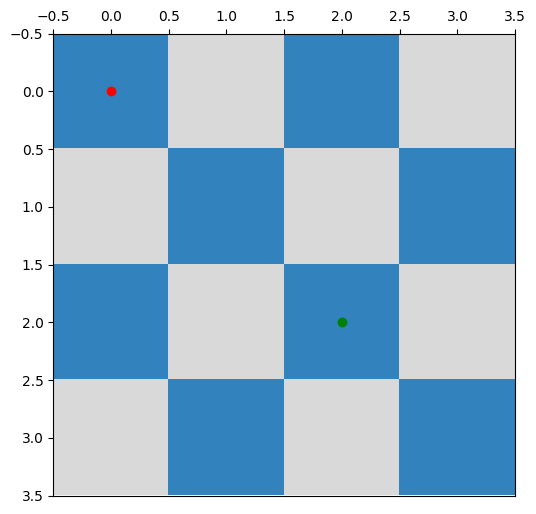

In [134]:
x = range(4)
y = range(4)
h,v = np.meshgrid(x,y)  #rect grid with vector coordinates (X,Y)
#min_max = np.min(x), np.max(x), np.min(y), np.max(y) 
res = np.add.outer(range(4), range(4))%2  # returns product of two vectors
positions=np.vstack([h.ravel(), v.ravel()]).T
start_position = choice(positions)
target_position = choice(positions)
possible_moves = [-1, 0, 1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

def draw_board():
    ax = plt.gca()
    ax.cla()
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    start_dot = ax.scatter(start_position[0],start_position[1],color="r")
    target_dot = ax.scatter(target_position[0],target_position[1],color="g")
    plt.imshow(res, cmap="tab20c")

if not np.array_equal(start_position,target_position):
    draw_board()


## Explore

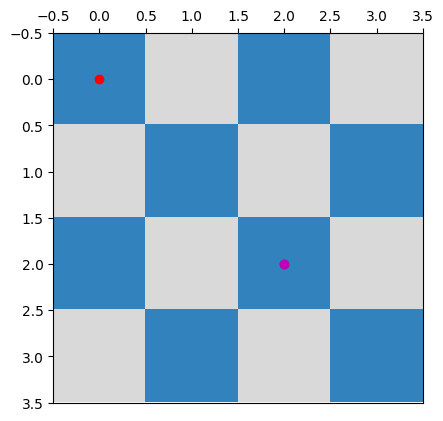

Target reached!
Total Steps: 19
Route: [[0, 0], [1, 0], [2, 0], [3, 0], [2, 0], [3, 0], [2, 0], [3, 0], [3, 1], [2, 1], [3, 1], [2, 1], [2, 2]]


In [135]:
route = []
stepcounter = 0
route.append([start_position[0], start_position[1]])
newposx, newposy = 0, 0

while True:
    clear_output(True)
    movex = choice(possible_moves)
    movey = choice(possible_moves)
    last_pos = route[-1]
    draw_board()
    sleep(0.2)
    if not movex == movey:
        if movex == 0 or movey == 0:
            newposx = last_pos[0] + movex
            newposy = last_pos[1] + movey
            if newposx >= 0 and newposx <= 3 and newposy >= 0 and newposy <= 3:
                # print(f"New pos: {newposx, newposy}")
                route.append([newposx, newposy])
                plt.scatter(newposx, newposy, color="m")
                plt.show()
            if newposx == target_position[0] and newposy == target_position[1]:
                print("Target reached!")
                
                plt.show()
                break
            stepcounter += 1

print(f"Total Steps: {stepcounter}")
print(f"Route: {route}",sep="\n")


## Build Table

In [136]:
# testlist = [[0, 0], [1, 0], [0, 0], [1, 0], [1, 1], [1, 2], [0, 2], [0, 1], [0, 2], [0, 1], [0, 2], [0, 1], [1, 1], [2, 1], [2, 0]]
i_list = [
    tuple(x) for x in route
]  # converts list into immutable list like [(1,3),(1,2)]
i_list = i_list[::-1]  # reverses the list to go the route backwards
vals = [[i_list[0], 1]]  # adds target position to list
multipliedrewards_list = dict.fromkeys(i_list)
i_list.pop(0)  # deletes target position from ttlist otherwise it would be a duplicate
q = 1
reward = 0.9
# create list with positions + rewarded values
for x in i_list:
    vals.append([x, math.pow(reward, q)])
    q += 1

# creates table with final reward values
# add value to table if not exist, otherwise multiply with existing value
pd.options.display.float_format = "{:,.5g}".format
df = pd.DataFrame(columns=[0, 1, 2, 3], index=[0, 1, 2, 3])
for x in vals:
    mrl_temp = multipliedrewards_list.get(x[0])
    if not mrl_temp:
        multipliedrewards_list[x[0]] = x[1]
    else:
        multipliedrewards_list[x[0]] = x[1] * mrl_temp
for x in multipliedrewards_list:
    df.at[x[0], x[1]] = multipliedrewards_list.get(x)

df_match_mesh = df.transpose(copy=True)  # swap axis so they match the meshgrid with x and y values
df_match_mesh

,0,1,2,3
0,0.28243,0.31381,0.079766,0.10942
1,NaN,NaN,0.6561,0.53144
2,NaN,NaN,1,NaN
3,NaN,NaN,NaN,NaN


## Exploit
Er soll alle felder drumherum checken und dann den nächst höheren nehmen 
danach: wenn die felder einen bestimmten Treshhold nicht überschreiten, nimm random.


In [137]:
for key, value in multipliedrewards_list.items():
    print(key, value)

(2, 2) 1
(2, 1) 0.6561000000000001
(3, 1) 0.531441
(3, 0) 0.1094189891315124
(2, 0) 0.07976644307687256
(1, 0) 0.31381059609000006
(0, 0) 0.2824295364810001


lastPOS: [1, 0]
(0, 0)


KeyboardInterrupt: 

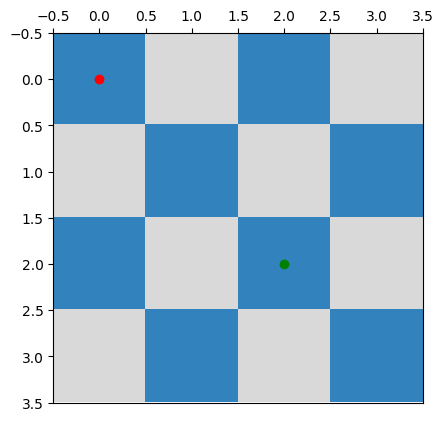

In [147]:
# test get max value from anliegenden feldern
# print(multipliedrewards_list)
# print(df.at[start_position[0], start_position[1]])
# print(df.iloc[start_position[0]][start_position[1]])

nn = [-1, 1]


def get_max_field(xpos, ypos):
    nghb_values = []
    for n in nn:
        newposx = xpos + n  # xpos = startposition[0]
        if newposx >= 0 and newposx <= 3:
            nghb_values.append(df_match_mesh[xpos + n][ypos])
        newposy = ypos + n
        if newposy >= 0 and newposy <= 3:
            nghb_values.append(df_match_mesh[xpos][ypos + n])
    # print(f"Neighbour values: {nghb_values}")
    max_value = max(nghb_values)
    # print(f"Max: {max_value}")
    for key, value in multipliedrewards_list.items():
        if value == max_value:
            # print("field of max value:")
            # print(f"Value: {value}")
            return key[0], key[1]


route = []
stepcounter = 0
route.append([start_position[0], start_position[1]])

while True:
    clear_output(True)
    last_pos = route[-1]
    print(f"lastPOS: {last_pos}")
    newpos = get_max_field(
        last_pos[0], last_pos[1]
    )  # best next field with highest value
    print(newpos)
    if last_pos == newpos:
        print("Fuck")
    draw_board()
    sleep(0.2)
    route.append([newpos[0], newpos[1]])
    plt.scatter(newpos[0], newpos[1], color="m")
    plt.show()
    if newpos[0] == target_position[0] and newpos[1] == target_position[1]:
        print("Target reached!")
        plt.show()
        break
    stepcounter += 1

print(f"Total Steps: {stepcounter}")
print(f"Route: {route}", sep="\n")